In [14]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import numpy as np
import joblib
%matplotlib inline

In [21]:
root = input('Введите путь к файлу: ')
data = pd.read_csv(root, sep = '	', index_col=False)

Введите путь к файлу:  Voxler_prism.txt


FileNotFoundError: [Errno 2] No such file or directory: 'Voxler_prism.txt'

In [8]:
unique_periods = data['T'].unique()
x_coords = sorted(data['X'].unique())
y_coords = sorted(data['Y'].unique())
periods = sorted(unique_periods)
print(len(x_coords),len(y_coords))

19 13


In [11]:
def data_2_array(df, invariant, dtype=float):
    df_pivot = df.pivot_table(
        values=invariant,
        index=['T', 'Y'],
        columns='X'
    ).sort_index(level=[0, 1])
    
    n_periods = len(periods)
    n_y = len(y_coords)
    n_x = len(x_coords)
    
    values = df_pivot.reindex(
        pd.MultiIndex.from_product([periods, y_coords], names=['T', 'Y'])
    ).values.reshape(n_periods, n_y, n_x)
    
    return values.astype(dtype)


In [12]:
Ref = data_2_array(data, 'Rho', float)

In [13]:
pivot_Rho = data.pivot_table(index=['T', 'Y'], columns='X', values='Rho')
pivot_Zxy = data.pivot_table(index=['T', 'Y'], columns='X', values='realZxy')
pivot_Zyx = data.pivot_table(index=['T', 'Y'], columns='X', values='realZyx')

In [35]:
def calculate_moving_average(pivot_multi):
    
    result_df = pivot_multi.copy()
    
    for period in pivot_multi.index.get_level_values('T').unique():
        period_data = pivot_multi.xs(period, level='T')
        
        data = period_data.values
        rows, cols = data.shape
        
        period_result = np.full_like(data, np.nan)
        
        for i in range(rows):
            for j in range(cols):
                row_start = max(0, i-1)
                row_end = min(rows, i+2) 
                col_start = max(0, j-1)
                col_end = min(cols, j+2)
                
                window = data[row_start:row_end, col_start:col_end]
                window_mean = np.nanmean(window)

                if not np.isnan(window_mean) and window_mean != 0:
                    period_result[i, j] = window_mean
                else:
                    period_result[i, j] = np.nan

        period_result_df = pd.DataFrame(
            period_result,
            index=period_data.index,  
            columns=period_data.columns 
        )
        
        for y_idx in period_data.index:
            result_df.loc[(period, y_idx), :] = period_result_df.loc[y_idx, :].values
    
    return result_df

In [36]:
smoothed_data_Rho = calculate_moving_average(pivot_Rho)
smoothed_data_Zyx = calculate_moving_average(pivot_Zxy)
smoothed_data_Zxy = calculate_moving_average(pivot_Zyx)
df_long_Rho = smoothed_data_Rho.stack().reset_index()
df_long_Rho.columns = ['T', 'Y', 'X', 'Rho_mean']
df_long_Zxy = smoothed_data_Zxy.stack().reset_index()
df_long_Zxy.columns = ['T', 'Y', 'X', 'Zxy_mean']
df_long_Zyx = smoothed_data_Zyx.stack().reset_index()
df_long_Zyx.columns = ['T', 'Y', 'X', 'Zyx_mean']
df_long = df_long_Rho.merge(df_long_Zyx)
df_long = df_long.merge(df_long_Zxy)

In [37]:
data_processed = data.merge(df_long)
data_processed['Rho_mean_attitude'] = data_processed['Rho']/data_processed['Rho_mean']
data_processed['Zxy_mean_attitude'] = data_processed['realZxy']/data_processed['Zxy_mean']
data_processed['Zyx_mean_attitude'] = data_processed['realZyx']/data_processed['Zyx_mean']

In [38]:
test = data_processed[['Rho','Rho_mean','Rho_mean_attitude','realZxy','realZyx','imagZxy','imagZyx']]
regressor = joblib.load('reg_classifier.joblib')
data_processed['K'] = regressor.predict(test)
KCoord = data_processed.groupby(['X', 'Y'])['K'].apply(list).reset_index()
KCoord['K_median'] = KCoord['K'].apply(np.median)
K_ml_pivot = KCoord.pivot_table(index= 'Y', columns='X', values='K_median')
Rho_ml = pivot_Rho.mul(K_ml_pivot, level='Y')
Rho_ml_df = Rho_ml.stack().reset_index()
Rho_ml_df.columns = ['T', 'Y', 'X', 'Rho_ml']     
data_processed = data_processed.merge(Rho_ml_df)
data_processed['Rho_K'] = data_processed['Rho']*data_processed['K']

In [39]:
def drow_lgGraph (T, coord):
    data = data_processed[(data_processed['T'] == T) & (data_processed['Y'] == coord)]
    data = data.sort_values('X')
    plt.figure(figsize=(10, 7))
    plt.plot(data['X'],data['Rho'], label='Rho_anomal', linestyle='-.')
    plt.plot(data['X'],data['Rho_ml'], label='Rho_ml', linestyle='--')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()
def drow_curve (X, Y):
    data = data_processed[(data_processed['X'] == X) & (data_processed['Y'] == Y)]
    data = data.sort_values('T')
    plt.figure(figsize=(7, 7))
    plt.plot(data['T'],data['Rho'], label='Rho_anomal', linestyle='-.')
    plt.plot(data['T'],data['Rho_ml'], label='Rho_ml', linestyle='--')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

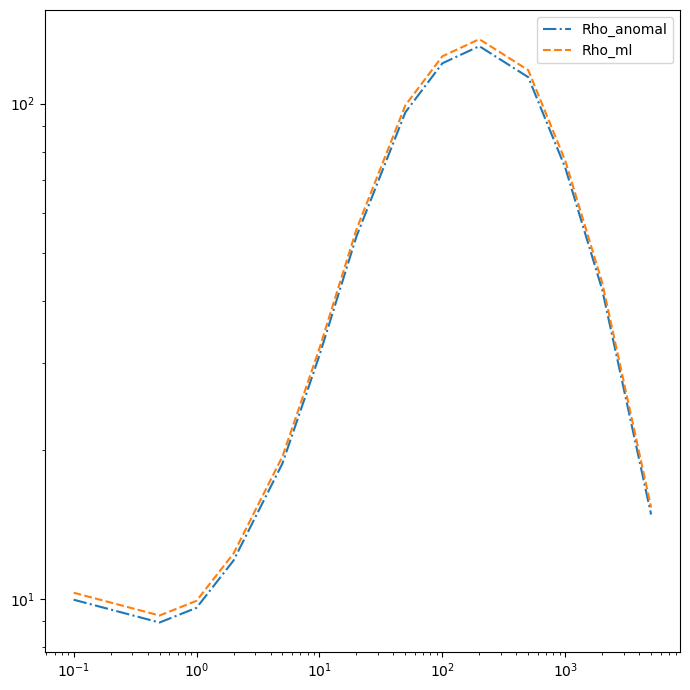

In [41]:
drow_curve(3000,3000)

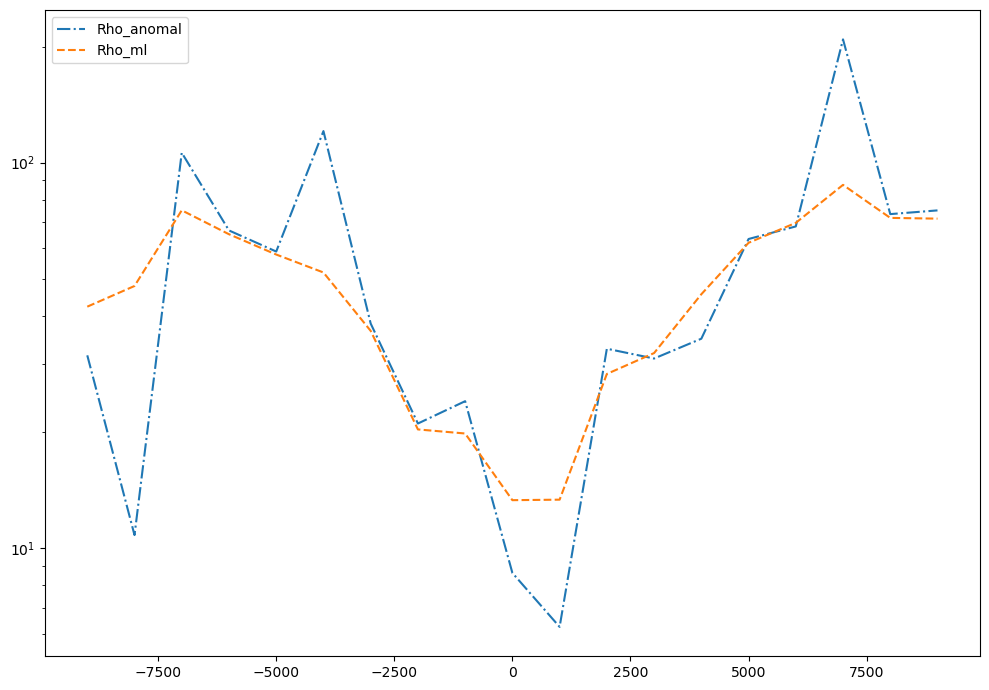

In [43]:
drow_lgGraph(10, 3000)